<a href="https://colab.research.google.com/github/HugoMagos0725/Analisis_de_datos/blob/main/Tarea3_Ajuste_de_parametros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**FCFM-BUAP, 2023**

## Proyecto: Ajuste de parametros
Nombre: Hugo Cuautle Magos

Matricula: 201847053

Materia: Análisis de datos

# Problema 1 

El archivo "Puebla_pos.cvs" son datos de los casos registrados (nuevos casos) para Puebla, reportados por la secretaría de salud. 

Carga los datos y grafica


In [1]:
import pandas as pd

from google.colab import drive 
drive.mount('/content/drive')

df=pd.read_csv('/content/drive/MyDrive/Puebla_pos.csv')
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,FECHA_SINTOMAS,positivo
0,2020-03-02,1
1,2020-03-05,2
2,2020-03-08,3
3,2020-03-09,4
4,2020-03-10,3
...,...,...
673,2022-01-09,493
674,2022-01-10,556
675,2022-01-11,287
676,2022-01-12,149


In [2]:
import matplotlib.pyplot as plt
from datetime import datetime 

df1=list(range(len(df['FECHA_SINTOMAS'])))

for i in df1:
  st=df['FECHA_SINTOMAS'][i]
  df1[i]=datetime.strptime(st,'%Y-%m-%d')

df['FECHA_SINTOMAS']=df1

In [3]:
import numpy as np

df['infectados']=np.cumsum(df['positivo'])
df

,FECHA_SINTOMAS,positivo,infectados
0,2020-03-02,1,1
1,2020-03-05,2,3
2,2020-03-08,3,6
3,2020-03-09,4,10
4,2020-03-10,3,13
...,...,...,...
673,2022-01-09,493,139030
674,2022-01-10,556,139586
675,2022-01-11,287,139873
676,2022-01-12,149,140022


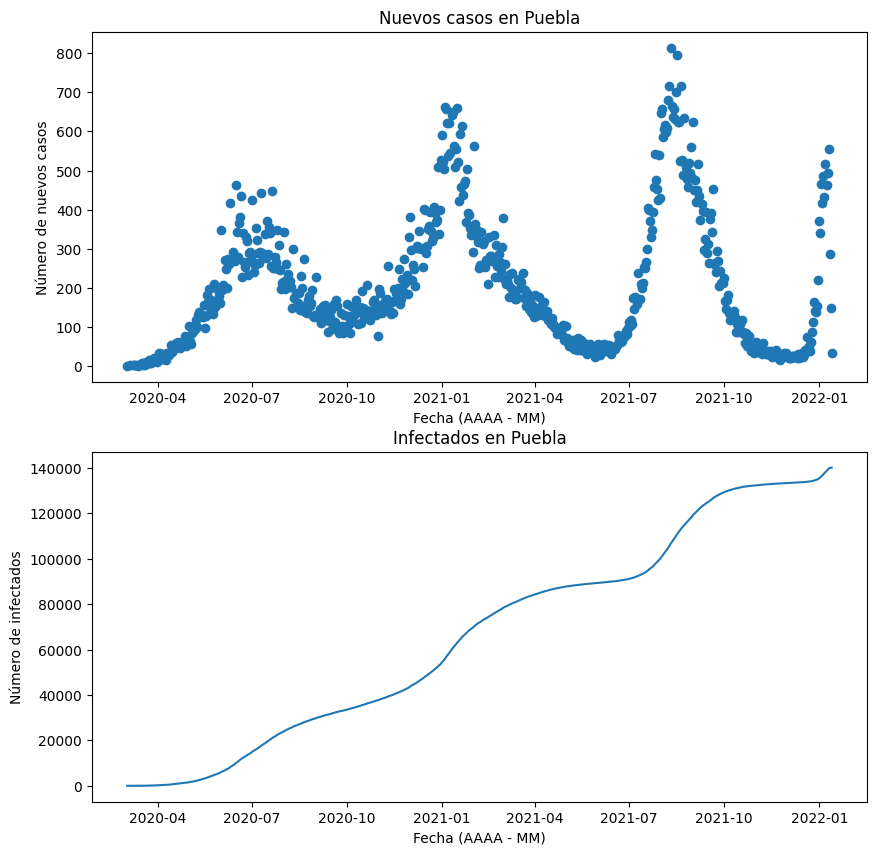

In [4]:
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
plt.title('Nuevos casos en Puebla')
plt.xlabel('Fecha (AAAA - MM)')
plt.ylabel('Número de nuevos casos')
plt.scatter(df['FECHA_SINTOMAS'],df['positivo'])
plt.subplot(2, 1, 2)
plt.title('Infectados en Puebla')
plt.xlabel('Fecha (AAAA - MM)')
plt.ylabel('Número de infectados')
plt.plot(df['FECHA_SINTOMAS'],df['infectados'])
plt.show()

# Problema 2 

Ajustar la primera ola con mínimos cuadrados. 

In [12]:
ind_inf=list(df['FECHA_SINTOMAS'].astype(str)).index('2020-04-10')
ind_sup=list(df['FECHA_SINTOMAS'].astype(str)).index('2020-10-10')
ind=ind_sup-ind_inf

primera_ola=df['positivo'][ind_inf:ind_sup].astype(int)
t = np.linspace(0, ind,ind)
primera_ola.index=list(range(len(primera_ola)))
print(primera_ola)

0       35
1       35
2       28
3       53
4       36
      ... 
178    155
179    124
180    129
181    133
182    133
Name: positivo, Length: 183, dtype: int64


In [6]:
from scipy import optimize
from scipy.integrate import odeint


def costo(x):
  b=x[0]
  g=x[1]
  def SIR(y,t,b,g):
    S=y[0]
    I=y[1]
    R=y[2]
    cum=y[3]

    N=S+I+R

    dS=-b*S*I/N
    dI=b*S*I/N-g*I
    dR=g*I
    dcum=b*S*I/N
    return np.array([dS,dI,dR,dcum])

  y0=[sum(primera_ola)-primera_ola[0],primera_ola[0],0,primera_ola[0]]
  model_pred=odeint(SIR,y0,t,args=(b,g))

  c=sum(np.array(primera_ola-model_pred[:,1])**2)
  return c

optimize.minimize(costo,[0.1,0.1],method='Nelder-Mead')

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 484030.9364926735
             x: [ 2.962e-01  2.579e-01]
           nit: 77
          nfev: 154
 final_simplex: (array([[ 2.962e-01,  2.579e-01],
                       [ 2.962e-01,  2.579e-01],
                       [ 2.962e-01,  2.579e-01]]), array([ 4.840e+05,  4.840e+05,  4.840e+05]))

In [7]:
def SIR(y,t):

    b=0.2962
    g=0.2579

    S=y[0]
    I=y[1]
    R=y[2]
    cum=y[3]

    N=S+I+R

    dS=-b*S*I/N
    dI=b*S*I/N-g*I
    dR=g*I
    dcum=b*S*I/N
    return np.array([dS,dI,dR,dcum])

y0=[sum(primera_ola)-primera_ola[0],primera_ola[0],0,primera_ola[0]]

model_pred=odeint(SIR,y0,t)

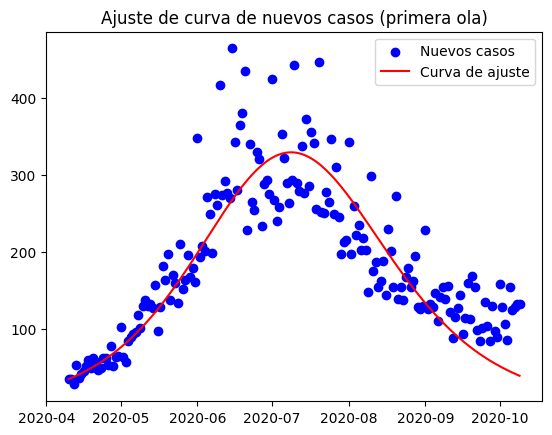

In [8]:
plt.title('Ajuste de curva de nuevos casos (primera ola)')
plt.scatter(df['FECHA_SINTOMAS'][ind_inf:ind_sup],df['positivo'][ind_inf:ind_sup],color='b')
plt.plot(df['FECHA_SINTOMAS'][ind_inf:ind_sup],model_pred[:,1],color='r')
plt.legend(['Nuevos casos','Curva de ajuste'])
plt.show()

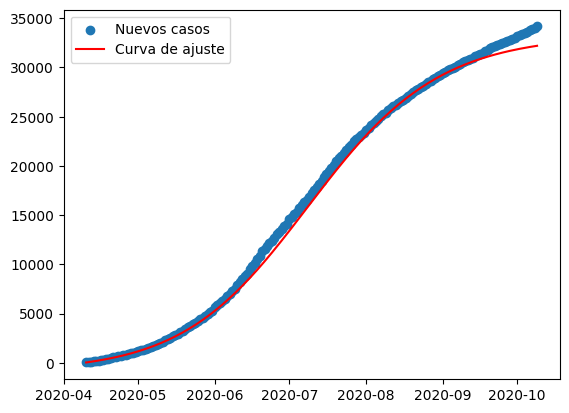

In [9]:
plt.scatter(df['FECHA_SINTOMAS'][ind_inf:ind_sup],np.cumsum(primera_ola))
plt.plot(df['FECHA_SINTOMAS'][ind_inf:ind_sup],np.cumsum(model_pred[:,1]),color='r')
plt.legend(['Nuevos casos','Curva de ajuste'])
plt.show()

# Problema 3 

Ajustar la segunda ola con  una cadena de Monte Carlo y dar intervalos de confianza para los parámetros. 

In [15]:
ind_inf2=ind_sup
ind_sup2=list(df['FECHA_SINTOMAS'].astype(str)).index('2021-05-15')
ind2=ind_sup2-ind_inf2

segunda_ola=df['positivo'][ind_inf2:ind_sup2].astype(int)
t2 = np.linspace(0, ind2,ind2)
segunda_ola.index=list(range(len(segunda_ola)))
print(segunda_ola)

0      168
1      108
2      144
3      150
4      111
      ... 
212     68
213     41
214     72
215     57
216     42
Name: positivo, Length: 217, dtype: int64
